<a href="https://colab.research.google.com/github/davidhuber/notebooks/blob/main/SassoCartaForbice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# General imports
import matplotlib.pyplot as plt
import pathlib
import skimage
import skimage.transform
#import skimage.viewer
import pandas as pd
import numpy as np
import time
import tensorflow as tf

import math
from matplotlib import colormaps

# Setup to show interactive jupyter widgets
from IPython.display import Image, display
from ipywidgets import interact, fixed
from ipywidgets import IntSlider

import ipywidgets as widgets

def imgplotList(i,data):
    plt.figure(figsize=(4,4))
    plt.imshow(data[i],interpolation="nearest")
    plt.show()

names = ["Sasso", "Carta", "Forbice"]


# Take image and resize to a specified size
def transform_simple(im,sz):
    imr = skimage.transform.resize(im, (sz,sz), )
    return imr

# Take image and resize to a specified size, after applying data augmentation
def transform_complex(im,sz):
    if(np.random.rand()<0.5):
        im=np.fliplr(im)
    tf1 = skimage.transform.SimilarityTransform(scale = 1 / im.shape[0])
    tf2 = skimage.transform.SimilarityTransform(translation=[-0.5, -0.5])
    tf3 = skimage.transform.SimilarityTransform(rotation=np.deg2rad(np.random.uniform(0,360)))
    tf4 = skimage.transform.SimilarityTransform(scale=np.random.uniform(1,1.6))
    tf5 = skimage.transform.SimilarityTransform(translation=np.array([0.5, 0.5])+np.random.uniform(-0.1,0.1,size=2))
    tf6 = skimage.transform.SimilarityTransform(scale=sz)
    imr = skimage.transform.warp(im, (tf1+(tf2+(tf3+(tf4+(tf5+tf6))))).inverse, output_shape=(sz,sz),mode="edge")
    imr = imr*np.random.uniform(0.9,1.1,size=(1,1,3))
    imr = np.clip(imr,0,1)
    return imr


# Raccolta Immagini



Le immagini devono contenere il gesto al centro, possibilmente con un po' di margine, ma non devono essere troppo piccole.

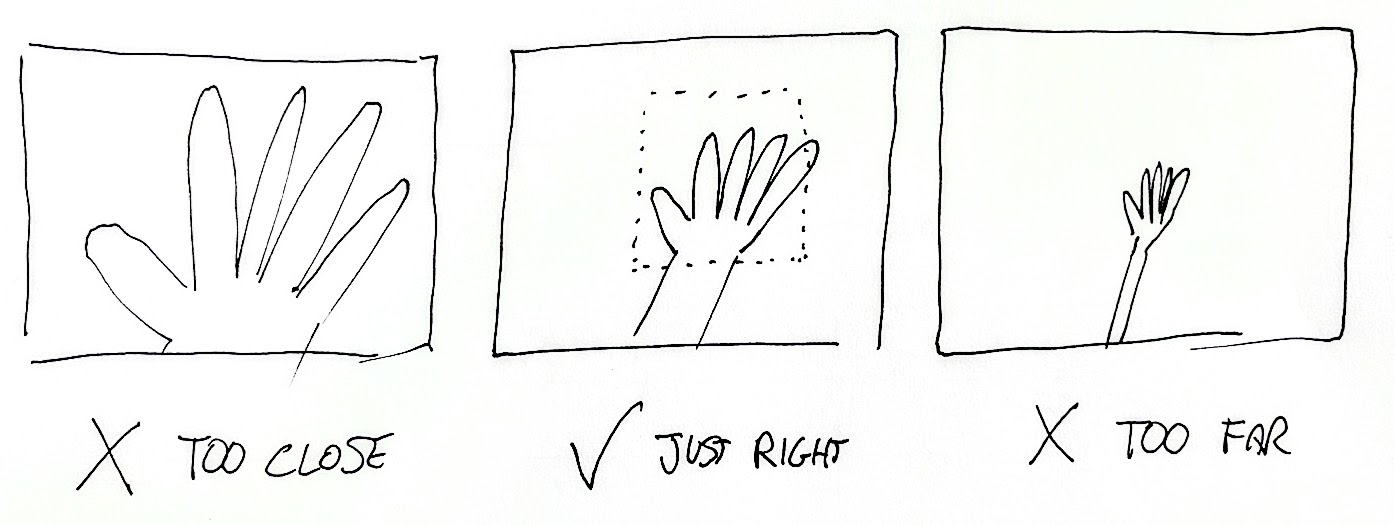

Prepariamo un dataset con 3 cartelle: c1, c2 e c3. In queste ci mettiamo rispettivamente i sassi, la carta e le forbici.

# Preparazione immagini
Iniziamo elencando tutte le immagini da considerare. Queste vegono prese da una cartella Dataset nel proprio Google Drive.

In [ ]:
# Define where datasets are located
dataset_directory = pathlib.Path("/content/drive/MyDrive/Dataset/final")

# Define which datasets we should consider.
# Each dataset is a directory withing dataset_directory
# and must contain three subdirectories: (c0, c1, c2) for (rock, paper, scissors).
dnames = ["D1","D2","D3","D4","D5","D6","D7", "D8", "testing"]

# Now check the data
ddirs=[dataset_directory/dn for dn in dnames] # directories of the dataset
cdirs={}
for ddir in ddirs:
    cdirs.update({ddir/"c0":0,
                  ddir/"c1":1,
                  ddir/"c2":2})

#names = ["Rock", "Paper", "Scissor"]

for cdir,cdir_class in cdirs.items():
    print(cdir)
    assert(cdir.exists())
    print("Found directory {} containing class {}".format(cdir,names[cdir_class]))

/content/drive/MyDrive/Dataset/final/D1/c0
Found directory /content/drive/MyDrive/Dataset/final/D1/c0 containing class Sasso
/content/drive/MyDrive/Dataset/final/D1/c1
Found directory /content/drive/MyDrive/Dataset/final/D1/c1 containing class Carta
/content/drive/MyDrive/Dataset/final/D1/c2
Found directory /content/drive/MyDrive/Dataset/final/D1/c2 containing class Forbice
/content/drive/MyDrive/Dataset/final/D2/c0
Found directory /content/drive/MyDrive/Dataset/final/D2/c0 containing class Sasso
/content/drive/MyDrive/Dataset/final/D2/c1
Found directory /content/drive/MyDrive/Dataset/final/D2/c1 containing class Carta
/content/drive/MyDrive/Dataset/final/D2/c2
Found directory /content/drive/MyDrive/Dataset/final/D2/c2 containing class Forbice
/content/drive/MyDrive/Dataset/final/D3/c0
Found directory /content/drive/MyDrive/Dataset/final/D3/c0 containing class Sasso
/content/drive/MyDrive/Dataset/final/D3/c1
Found directory /content/drive/MyDrive/Dataset/final/D3/c1 containing class Ca

Carica tutte le immagini e ritaglia una regione quadrata dal centro. L'immagine viene poi ridimensionata 500x500 pixel. Avremo dunque un insieme di immagini tutte di dimensione e formato uguale, indipendentemente se era verticali o orizontali.

Salviamo il tutto in un pandas dataframe con 3 colonne:
* image: le immagini appena ridimensionate e salvate come uint8 numpy array
* label: il gesto salvato come 0, 1 or 2
* file: Il percorso completo dell'immagine

Nota: questa operazione potrebbe richiedere un po' di tempo

In [ ]:
imagesize = 500

dataset=[]

import warnings

from tqdm import tqdm
for cdir,cn in list(cdirs.items()):
    for f in tqdm(list(cdir.glob("*")), desc=str(cdir).split('/')[-2]):
        try:
            im=skimage.io.imread(f)
            h,w=im.shape[0:2] # height, width
            if (w!=500) or (h!=500):
                sz=min(h,w)
                im=im[(h//2-sz//2):(h//2+sz//2),(w//2-sz//2):(w//2+sz//2),:] # defines the central square
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    im=skimage.img_as_ubyte(skimage.transform.resize(im,(imagesize,imagesize))) # resize it to 500x500, whatever the original resolution
            else:
              im=skimage.img_as_ubyte(im)
        except:
            warnings.warn("ignoring "+str(f))
            continue

        dataset.append({
            "file":f,
            "label":cn,
            "image":im})

print("Done")

testing: 100%|██████████| 31/31 [00:00<00:00, 114.77it/s]

Done


Aggiungiamo nel dataset una colonna "dn" contenente il nome del dataset.

In [ ]:
dataset=pd.DataFrame(dataset)
dataset["dn"]=dataset["file"].apply(lambda x: x.parent.parts[-2])

Salviamo il risultato in un unico file.

In [ ]:
dataset.to_pickle("/content/drive/MyDrive/dataset.pickle")

# Caricamento Immagini preprocessate
La preparazione di immagini può richiedere molto tempo. Per convenienza, il ritaglio e ridimensionamento è stato eseguito in precedenza e salvato in un file Pickle.


In [ ]:
dataset = pd.read_pickle("/content/drive/MyDrive/dataset.pickle")

Veloce sguardo ad alcune immagini.

In [ ]:
@interact(image=IntSlider(min=0, max=dataset.shape[0]-1))
def scroll_images(image):
  plt.imshow(dataset.iloc[image].image)
  plt.show()

interactive(children=(IntSlider(value=0, description='image', max=2431), Output()), _dom_classes=('widget-inte…

# Separazione dati per apprendimento e valutazione

Come suddividere le immaini per apprendere da quelle per valutare l'apprendimento?

Suddividiamo a caso le foto in training (apprendimento) e test (verifica).

In [ ]:
dataset.shape

(2432, 4)

Prendiamo 200 immagini per testare il modello

In [ ]:
dataset_te = dataset.sample(200, random_state=31)

Le restanti per allenarlo

In [ ]:
# In any case, training samples are all other samples
dataset_tr=dataset.loc[dataset.index.difference(dataset_te.index)]

In [ ]:
# Print a summary of how many training and testing images we have sampled
import collections
pd.DataFrame(index=[0,1,2],data=collections.OrderedDict((
    ("Class name",           names),
    ("# Training images", dataset_tr["label"].value_counts()),
    ("# Testing images",  dataset_te["label"].value_counts())))).set_index("Class name")

,# Training images,# Testing images
Class name,,
Sasso,745,70
Carta,727,61
Forbice,760,69


# Dimensione immagini

In [ ]:
# The resolution challenge
@interact(sz = widgets.IntSlider(min=2,max=100),
          seed = widgets.IntSlider(min=0,max=100),
          reveal = widgets.widgets.ToggleButton(value=False,description='Reveal'))
def f(sz,seed,reveal):
    print("Pixel: ", sz*sz)
    fig,axs = plt.subplots(nrows = 2, ncols = 2,figsize=(4,4),dpi=150)
    ims = dataset.sample(len(axs.flatten()), random_state=seed)
    for ax,(_,row) in zip(axs.flatten(),ims.iterrows()):
        ax.imshow(transform_simple(row["image"],sz))
        ax.axis("off")
        if(reveal):
            ax.set_title(names[row["label"]])
    plt.show()

interactive(children=(IntSlider(value=2, description='sz', min=2), IntSlider(value=0, description='seed'), Tog…

# Preparazione dati per il modello

In [ ]:
#transform=transform_simple
transform=transform_complex

In [ ]:
def sample(df,sz):
    r = df.sample(n=1)
    l = r["label"].iloc[0]
    im = r["image"].iloc[0]
    im = transform(im,sz)
    return im,l

def mkbatch(df,N,sz):
    X = []
    y = []
    for i in range(N):
        im,l = sample(df,sz)
        X.append(im)
        y.append(l)
    X = np.array(X).astype('float32')
    y = np.array(y)
    y = tf.keras.utils.to_categorical(y,3)
    return X,y

def generator(df,batch_size,sz):
    while True:
        X,y = mkbatch(df,batch_size,sz)
        yield (X,y)


In [ ]:
# Visualize 100 images from our input dataset
examples = list(mkbatch(dataset_tr,100,32)[0])
interact(imgplotList, i=widgets.IntSlider(min=0, max=len(examples)-1, step=1, value=0,continuous_update=False), data=fixed(examples))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=99), Output()), _dom_cl…

<function __main__.imgplotList(i, data)>

In [ ]:
from ipywidgets.widgets.widget_bool import ToggleButton
examples = list(mkbatch(dataset_tr.iloc[[0]],100,32)[0])
@interact(i=IntSlider(min=0, max=dataset_tr.shape[0], continuous_update=False),
          generate=ToggleButton())
def variations(i,generate):
    image = transform_complex(dataset_tr.iloc[i].image, 32)
    plt.imshow(image)
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=2232), ToggleButton(val…

#Creazione modello

Il modello utilizzato è una rete neurale convoluzionale. Questa si compone di una successione di operazioni di trasformazione immagini per terminare in una rete neurale completamente connessa.

Obiettivo dell'apprendimento è stimare i valori dei parametri che meglio permettono di prevedere la classe.

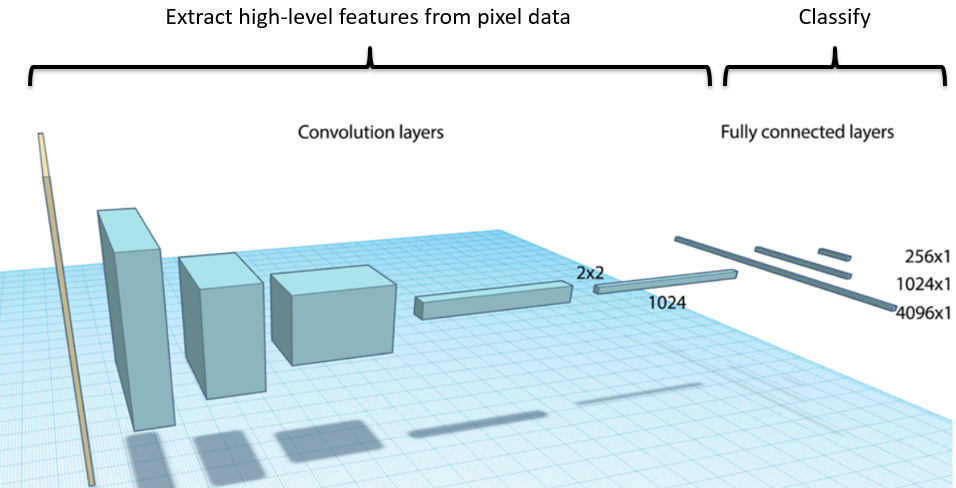

In [ ]:
import keras

from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout


# NN settings
patchsize          = 32
batch_size         = 32
pool_size          = (2,2) # size of pooling area for max pooling
kernel_size        = (3,3) # convolution kernel size

def makeModel(nb_filters):
    model = Sequential()
    model.add(Conv2D(nb_filters, kernel_size, input_shape=(patchsize,patchsize,3), padding = "same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Conv2D(nb_filters*2, kernel_size, padding = "same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Conv2D(nb_filters*4, kernel_size, padding = "same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(AveragePooling2D(pool_size = pool_size))
    model.add(Flatten())
    model.add(Dense(128)) # generate a fully connected layer wiht 128 outputs (arbitrary value)
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3)) # output layer
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

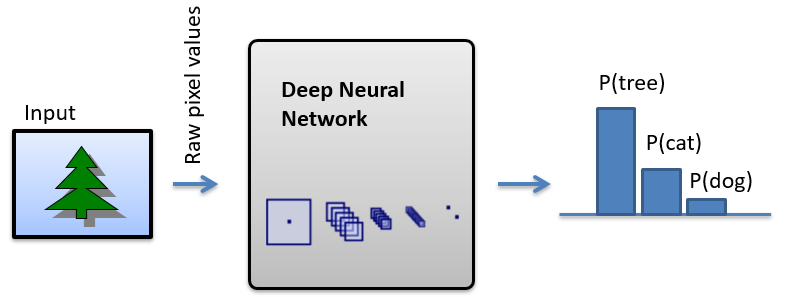

In [ ]:
(X_test,y_test) = mkbatch(dataset_te, 1000, patchsize)

# Allena il modello

Utilizzando le immagini di trianing istruiamo il sistema a imparare il modello. Durante l'apprendimento il modello viene valutato sui dati di test per avere se stiamo imparando a ricordare o a prevedere.

In [ ]:
modelid = time.strftime("%Y%m%d%H%M%S")

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=50),
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/model_checkpoint_best_{}.h5'.format(modelid),
        monitor='val_loss',
        save_best_only=True)
]

model = makeModel(32)
history=model.fit(generator(dataset_tr, batch_size, patchsize),
                    steps_per_epoch=50,
                    epochs=250,
                    verbose=1,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks_list)

Epoch 1/250
50/50 [==============================] - 27s 285ms/step - loss: 1.1033 - accuracy: 0.3444 - val_loss: 1.0975 - val_accuracy: 0.3390
Epoch 2/250
 1/50 [..............................] - ETA: 0s - loss: 1.0873 - accuracy: 0.4375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 13s 264ms/step - loss: 1.0988 - accuracy: 0.3544 - val_loss: 1.0983 - val_accuracy: 0.3390
Epoch 3/250
50/50 [==============================] - 14s 283ms/step - loss: 1.0972 - accuracy: 0.3556 - val_loss: 1.0982 - val_accuracy: 0.3390
Epoch 4/250
50/50 [==============================] - 14s 282ms/step - loss: 1.0991 - accuracy: 0.3450 - val_loss: 1.0957 - val_accuracy: 0.3660
Epoch 5/250
50/50 [==============================] - 14s 280ms/step - loss: 1.0985 - accuracy: 0.3494 - val_loss: 1.0940 - val_accuracy: 0.3410
Epoch 6/250
50/50 [==============================] - 14s 277ms/step - loss: 1.0967 - accuracy: 0.3481 - val_loss: 1.0889 - val_accuracy: 0.4190
Epoch 7/250
50/50 [==============================] - 13s 272ms/step - loss: 1.0984 - accuracy: 0.3781 - val_loss: 1.0945 - val_accuracy: 0.3470
Epoch 8/250
50/50 [==============================] - 14s 291ms/step - loss: 1.0980 - accuracy: 0.3544 - val_loss: 1.0938 - val_accuracy: 0.3600
Epoc

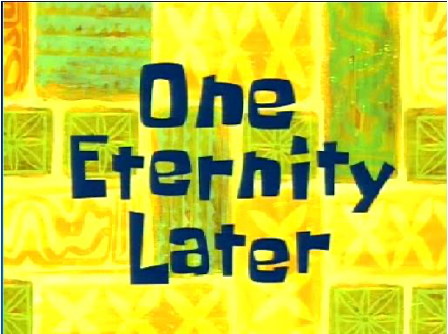

In [ ]:
# Save model to a file
tf.keras.models.save_model(model, "/content/drive/MyDrive/final_model.model")

# Testiamo il modello

Prepariamo alcune immagini per testare il modello

In [ ]:
(X_test,y_test) = mkbatch(dataset_te, 1000, patchsize)

# Risultati


In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/final_model.model")

In [ ]:
bestmodel = tf.keras.models.load_model("/content/drive/MyDrive/model_checkpoint_best_20231105115448.h5")

In [ ]:
Y_pred = bestmodel.predict(X_test)

32/32 [==============================] - 1s 36ms/step


Misuriamo quanto è bravo il modello a prevedere dati mai visti.

In [ ]:

print("Accuratezza:", sum(np.argmax(y_test, axis=1) == np.argmax(Y_pred, axis=1)) / 10, "%")

Accuratezza: 85.0 %


In [ ]:
@interact(i=IntSlider(min=0, max=Y_pred.shape[0], continuous_update=False))
def show(i):
  fig, ax = plt.subplots(1,2, figsize=(8,3))
  ax[0].imshow(X_test[i])
  ax[1].bar(names,Y_pred[i])
  plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=1000), Output()), _dom_…

# Cosa vede il modello

In [ ]:
bestmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                   

In [ ]:
# title Default title text
livelli = [0,1,2,3,5,8,10]
immagini = 5
Y_pred = bestmodel.predict(X_test)

@interact(image=IntSlider(min=0, max=Y_pred.shape[0], continuous_update=False))
def show_layer(image):
    fig, ax = plt.subplots(immagini, len(livelli), figsize=(10,8))
    for xx, l in enumerate(livelli):
      if xx > 0:
        m2 = Sequential(bestmodel.layers[:l])
        l_pred = m2.predict(np.array([X_test[image]]), verbose=False)
        x = l_pred[0]
        for yy in range(immagini):
          index = yy
          ax[yy,xx].imshow(x[:,:,index], cmap="gray")
          ax[yy,xx].axis("off")

      else:
        ax[0,0].imshow(X_test[image])
        ax[1,0].bar(["s","c","f"], Y_pred[image])
        for yy in range(immagini): ax[yy,xx].axis("off")

    plt.show()

32/32 [==============================] - 1s 39ms/step


interactive(children=(IntSlider(value=0, continuous_update=False, description='image', max=1000), Output()), _…

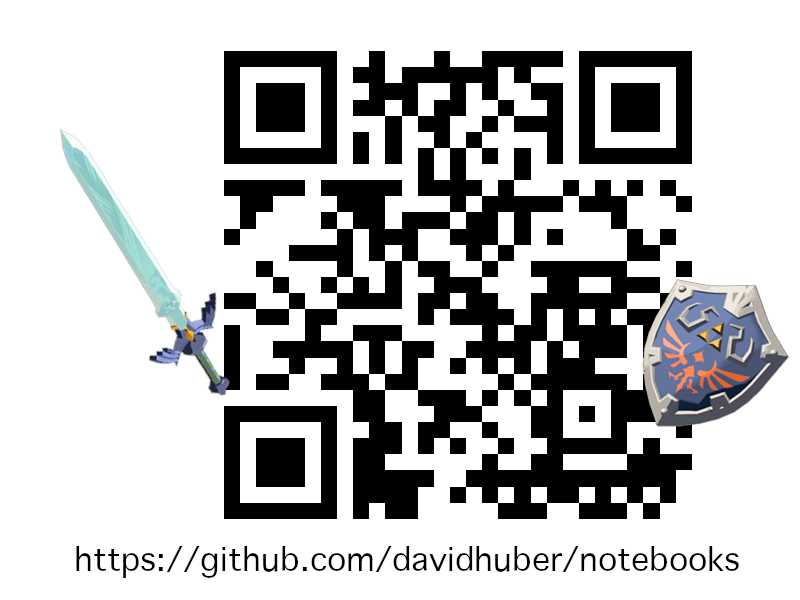

In [ ]:
im=skimage.img_as_ubyte(skimage.io.imread("/content/drive/MyDrive/cartoon-hand.jpg"))

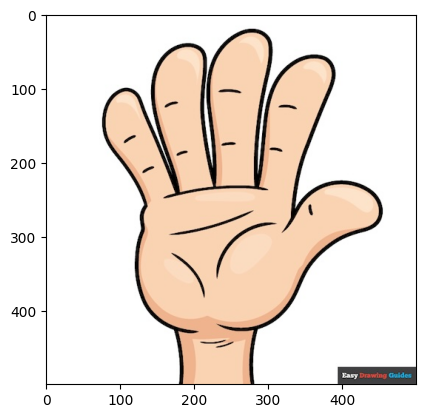

In [ ]:
plt.imshow(im)

In [ ]:
p = bestmodel.predict(np.array([transform_simple(im, patchsize)]), verbose=0)

print(names[np.argmax(p[0])])

Carta
